<a href="https://colab.research.google.com/github/MuhammadaliMS/Sentiment_extraction/blob/master/tweet_sentiment_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
path = "/content/drive/My Drive/Data/tweet-sentiment-extraction/train.csv"
path1 = "/content/drive/My Drive/Data/tweet-sentiment-extraction/test.csv"

In [5]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
train = pd.read_csv(path)
test = pd.read_csv(path1)
print(train.shape)
train.head()

(27481, 4)


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [8]:
train.dropna(inplace=True)

In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


In [10]:
train.describe()

,textID,text,selected_text,sentiment
count,27480,27480,27480,27480
unique,27480,27480,22463,3
top,d9367b79ab,"ugh, i dont feel like going to work today",good,neutral
freq,1,1,199,11117


In [11]:
train.groupby('sentiment').count()['text'].reset_index()

,sentiment,text
0,negative,7781
1,neutral,11117
2,positive,8582


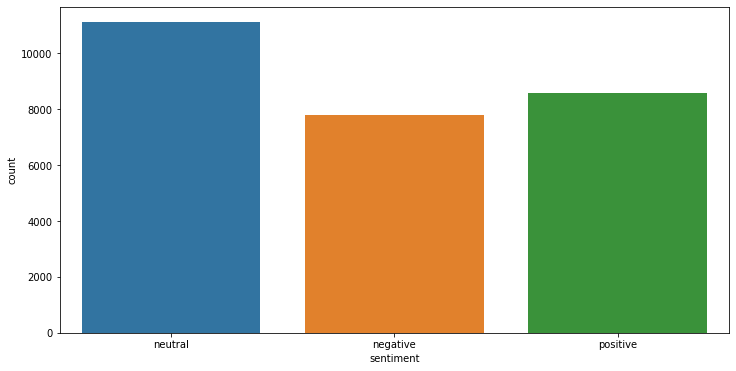

In [12]:
plt.figure(figsize = (12,6))
sns.countplot(x= 'sentiment', data= train)

Finding the Jaccard Similarity

In [13]:
def jaccard(str1,str2):
  a= set(str1.lower().split())
  b= set(str2.lower().split())
  c= a.intersection(b)
  return float(len(c))/(len(a)+len(b)-len(c))

In [14]:
results_jaccard= []
for ind, row in train.iterrows():
  sentence1 = row.text
  sentence2 = row.selected_text
  jaccard_score = jaccard(sentence1,sentence2)
  results_jaccard.append([sentence1,sentence2,jaccard_score])
  

In [15]:
jaccard = pd.DataFrame(results_jaccard,columns=['text','selected_text','jaccard_score'])
train =train.merge(jaccard,how='outer')

In [16]:
train.groupby('sentiment')['jaccard_score'].mean()

sentiment
negative    0.338613
neutral     0.976445
positive    0.314372
Name: jaccard_score, dtype: float64

In [17]:
train['num_of_words_st'] = train['selected_text'].apply(lambda x: len(str(x).split()))
train['num_of_words_text'] = train['text'].apply(lambda x: len(str(x).split()))
train['difference']= train['num_of_words_text']-train['num_of_words_st']


In [18]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,num_of_words_st,num_of_words_text,difference
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000,7,7,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,2,5,3
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,3,5,2
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.214286,3,14,11


In [19]:
hist_data = [train['num_of_words_st'],train['num_of_words_text']]
group_labels= ['selected_text', 'text']
fig = ff.create_distplot(hist_data,group_labels,)
fig.show()

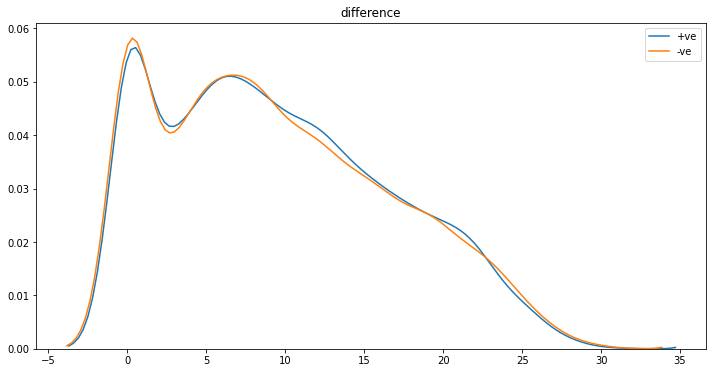

In [20]:
plt.figure (figsize = (12,6))
p1= sns.kdeplot(train[train['sentiment']=='positive']['difference'], label ='+ve').set_title('difference')
p2 = sns.kdeplot(train[train['sentiment']=='negative']['difference'], label ='-ve')

In [21]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [22]:
train['text'] = train['text'].apply(lambda x: clean_text(x))
train['selected_text'] = train['selected_text'].apply(lambda x: clean_text(x))

In [23]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,num_of_words_st,num_of_words_text,difference
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,1.000000,7,7,0
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me,bullying me,negative,0.166667,2,5,3
3,9642c003ef,what interview leave me alone,leave me alone,negative,0.600000,3,5,2
4,358bd9e861,sons of why couldnt they put them on the rel...,sons of,negative,0.214286,3,14,11


In [24]:
#most common words
train['split_text']=train['selected_text'].apply(lambda x: str(x).split())
top =Counter([item for sublist in train['split_text'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['common_words', 'count'] 
temp


,common_words,count
0,i,7200
1,to,5305
2,the,4590
3,a,3538
4,my,2783
5,you,2624
6,and,2321
7,it,2158
8,is,2115
9,in,1986


In [25]:
fig = px.bar(temp, x ='count', y = 'common_words', orientation ='h')
fig.show()

In [26]:
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]


In [27]:
train['split_text'] = train ['split_text'].apply(lambda x: remove_stopword(x))
top =Counter([item for sublist in train['split_text'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['common_words', 'count'] 
temp

,common_words,count
0,im,1676
1,good,1251
2,day,1058
3,love,909
4,happy,852
5,like,774
6,get,772
7,dont,765
8,go,700
9,cant,613


In [28]:
train['split_text']=train['text'].apply(lambda x: str(x).split())
train['split_text'] = train ['split_text'].apply(lambda x: remove_stopword(x))
top =Counter([item for sublist in train['split_text'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['common_words', 'count'] 
temp



,common_words,count
0,im,3020
1,day,2044
2,good,1549
3,get,1426
4,like,1346
5,go,1267
6,dont,1200
7,love,1122
8,work,1112
9,going,1096


In [29]:
fig = px.bar(temp, x ='count', y = 'common_words', orientation ='h')
fig.show()

In [30]:
selected_postive = train[train['sentiment']=='positive']
selected_negative  = train[train['sentiment']== 'negative']
selected_neutral  = train[train['sentiment']== 'neutral']

In [31]:
def show_common(y):
  y['split_text']=y['text'].apply(lambda x: str(x).split())
  y['split_text'] = y ['split_text'].apply(lambda x: remove_stopword(x))
  top =Counter([item for sublist in y['split_text'] for item in sublist])
  temp = pd.DataFrame(top.most_common(20))
  temp.columns = ['common_words', 'count'] 
  return temp

def show_treemap(y):
  fig = px.treemap(y, names='common_words', values='count',title='Tree Of Most Common  Words')
  fig.show()



In [32]:
top_positive = show_common(selected_postive)
top_negative = show_common(selected_negative)
top_neutral = show_common(selected_neutral)
top_positive

,common_words,count
0,day,1223
1,good,1046
2,love,875
3,happy,840
4,im,740
5,mothers,627
6,thanks,553
7,great,478
8,like,413
9,hope,396


In [33]:
show_treemap(top_positive)

In [34]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout() 

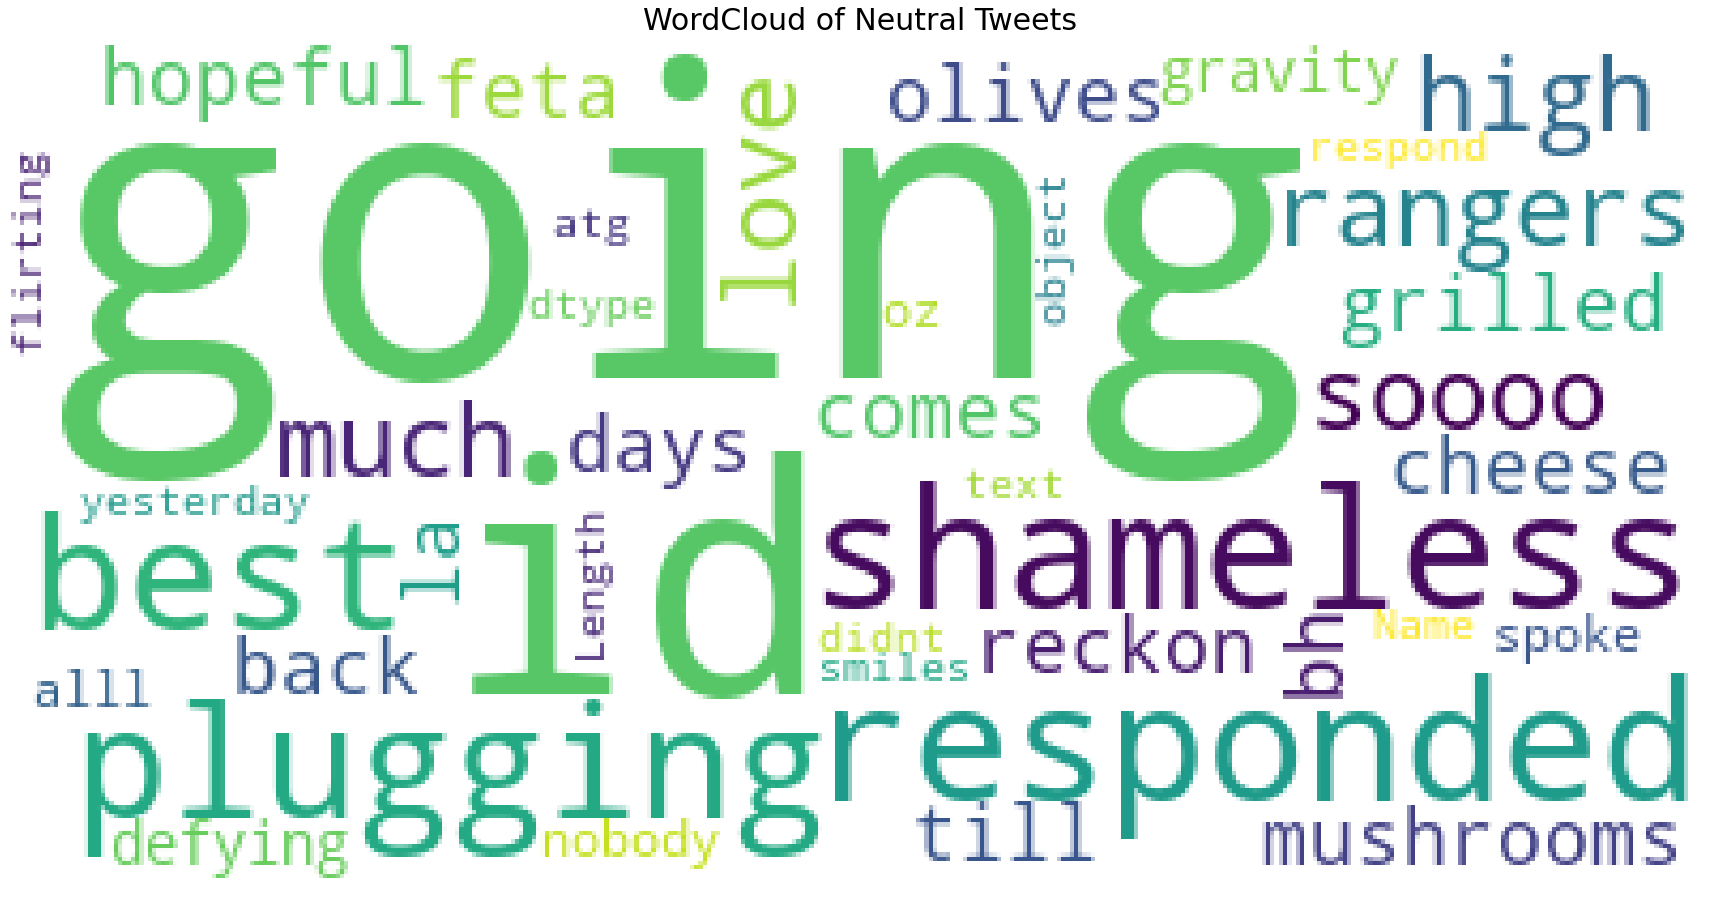

In [35]:
plot_wordcloud(selected_neutral.text,color='white',max_font_size=100,title_size=30,title="WordCloud of Neutral Tweets")

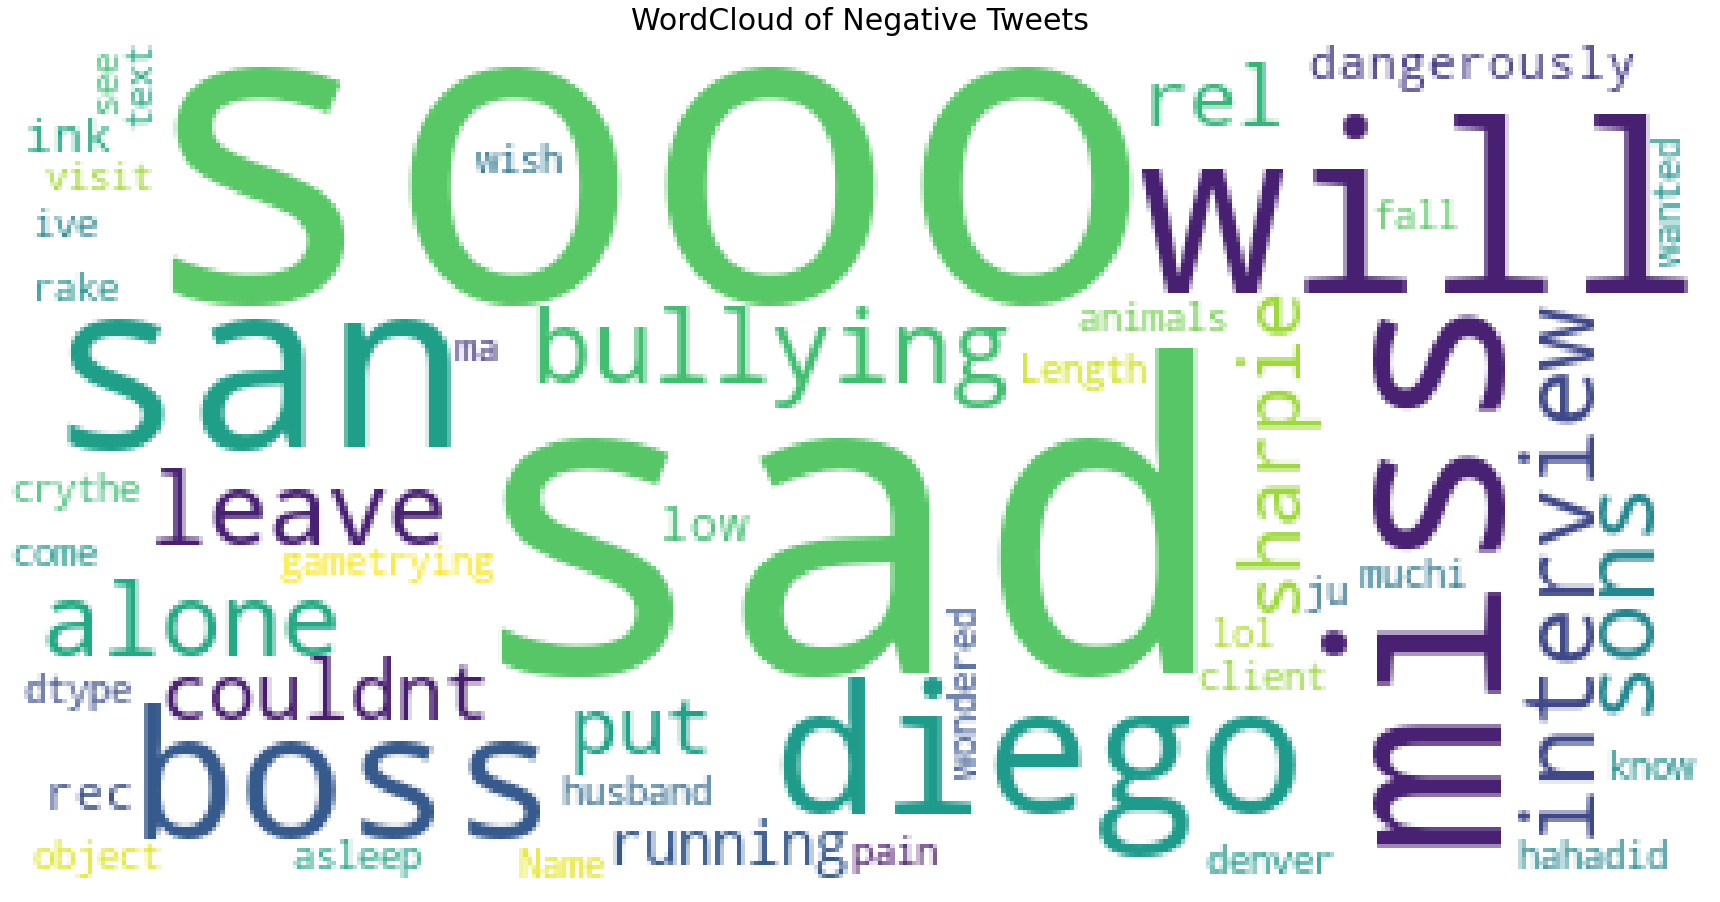

In [36]:
plot_wordcloud(selected_negative.text,color='white',max_font_size=100,title_size=30,title="WordCloud of Negative Tweets")

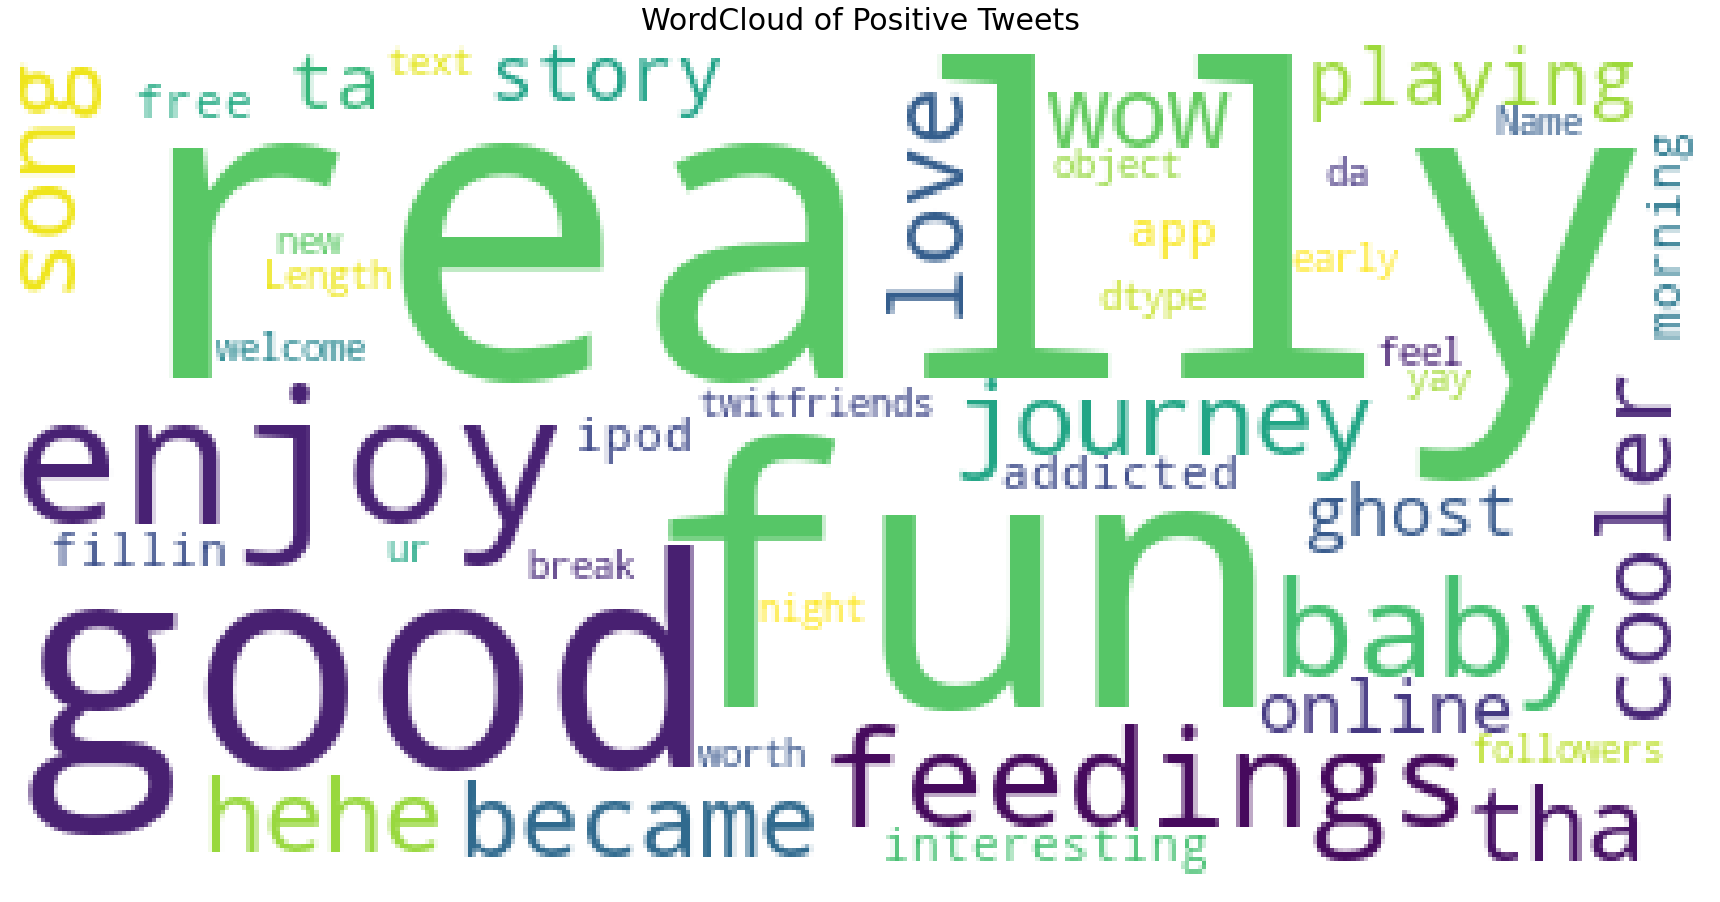

In [37]:
plot_wordcloud(selected_postive.text,color='white',max_font_size=100,title_size=30,title="WordCloud of Positive Tweets")

the current problem can also be converted to a QA task wherein:

Question == Sentiment column

Reference Text == Text column

Answer == Selected Text column

Selected text column is a portion of the text column.Hence, it can be simply represented as START and END tokens.

Therefore, our training data will consist of Text columns(concatenated Sentiment column and Text column) and labels will consist of the the start and end tokens of the selected text.

## **Tokenization**

In [38]:
!pip install transformers
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


     |████████████████████████████████| 778kB 4.4MB/s 
     |████████████████████████████████| 3.0MB 84kB/s 
     |████████████████████████████████| 1.1MB 41.7MB/s 
     |████████████████████████████████| 890kB 44.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=ef55b13f6a71319ce7ab37c0226edb6a3d608bfdf39a9c6df9042610ffa8099b
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


**Preprocessing data for Bert**

BERT expects input data in a specific format i.e

Tokenized dataset

All the vectors should be of the same size.Hence,we need to pad the text to achieve a common length.This length will be decided by the length of longest sentence, which we will have to calculate.Also, since we shall concatanate the text and the sentiment column, the length should be decided by the concatanated text column.

We need to then differentiate between the Actual tokens and the Padded ones with the help of "Attention Masks".

In [39]:
max_len = 0
for text in train['text']:
  input_ids = tokenizer.encode(text, add_special_tokens =True)
  max_len = max( max_len, len(input_ids))
print(max_len)

53


In [40]:
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [41]:
test['text']= test['text'].apply(lambda x: clean_text(x))

In [42]:
test.head()

,textID,text,sentiment
0,f87dea47db,last session of the day,neutral
1,96d74cb729,shanghai is also really exciting precisely s...,positive
2,eee518ae67,recession hit veronique branquinho she has to ...,negative
3,01082688c6,happy bday,positive
4,33987a8ee5,i like it,positive


In [43]:
max_len = 0
for text in test['text']:
  input_ids = tokenizer.encode(text, add_special_tokens =True)
  max_len = max( max_len, len(input_ids))
print(max_len)

48


In [45]:
MAX_LEN = 96
from transformers import RobertaModel, RobertaTokenizer
roberta = RobertaModel.from_pretrained('roberta-base')
tokenizer = tokenizers.ByteLevelBPETokenizer(
    vocab_file=PATH+'vocab-roberta-base.json', 
    merges_file=PATH+'merges-roberta-base.txt', 
    lowercase=True,
    add_prefix_space=True
)
ct = train.shape[0]
input_ids = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask = np.zeros((ct,MAX_LEN),dtype='int32')
token_type_ids = np.zeros((ct,MAX_LEN),dtype='int32')
start_tokens = np.zeros((ct,MAX_LEN),dtype='int32')
end_tokens = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(train.shape[0]):
    
    # FIND OVERLAP
    text1 = " "+" ".join(train.loc[k,'text'].split())
    text2 = " ".join(train.loc[k,'selected_text'].split())
    idx = text1.find(text2)
    chars = np.zeros((len(text1)))
    chars[idx:idx+len(text2)]=1
    if text1[idx-1]==' ': chars[idx-1] = 1 
    enc = tokenizer.encode(text1) 
        
    # ID_OFFSETS
    offsets = []; idx=0
    for t in enc.ids:
        w = tokenizer.decode([t])
        offsets.append((idx,idx+len(w)))
        idx += len(w)
    
    # START END TOKENS
    toks = []
    for i,(a,b) in enumerate(offsets):
        sm = np.sum(chars[a:b])
        if sm>0: toks.append(i) 
        
    s_tok = sentiment_id[train.loc[k,'sentiment']]
    input_ids[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_tok] + [2]
    attention_mask[k,:len(enc.ids)+5] = 1
    if len(toks)>0:
        start_tokens[k,toks[0]+1] = 1
        end_tokens[k,toks[-1]+1] = 1

NameError: ignored

In [ ]:

ct = test.shape[0]
input_ids_t = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask_t = np.zeros((ct,MAX_LEN),dtype='int32')
token_type_ids_t = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(test.shape[0]):
        
    # INPUT_IDS
    text1 = " "+" ".join(test.loc[k,'text'].split())
    enc = tokenizer.encode(text1)                
    s_tok = sentiment_id[test.loc[k,'sentiment']]
    input_ids_t[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_tok] + [2]
    attention_mask_t[k,:len(enc.ids)+5] = 1